# Lab 2: Data Preparation

# Craig Phayer - 21340633

In the previous lab exercise, you practised performing exploratory data analysis (EDA) of a dataset without making changes to the dataset. Once you have a good understanding of the dataset, a next step in the data analytics process is to prepare this dataset for more elaborate analysis that typically involves machine learning algorithms. This preparation is known as data munging or data wrangling, and it typically involves:

encoding categorical features as numerical,
filling in missing values,
rescaling numerical features (i.e. columns) or normalising examples,
appropriately treating outliers/extreme values,
creating new features (i.e. columns) from the existing ones.
At the end of this lab exercise, you should be able to apply commonly used techniques for data preparation.

### Task 1
Download the following dataset and example Jupyter notebook:

[loans_train.csv](https://learn.ul.ie/content/enforced/49261-CS4168_SEM2_2024_5/1.Resources/loans_train.csv)

[Lab 2 - Data Preparation.ipynb](https://learn.ul.ie/content/enforced/49261-CS4168_SEM2_2024_5/1.Resources/Lab%202%20-%20Data%20Preparation.ipynb)

### Task 2
Download the dataset: [bank.csv.](https://learn.ul.ie/content/enforced/49261-CS4168_SEM2_2024_5/1.Resources/bank.csv)

### Task 3
Open a new Jupyter notebook. In your notebook, load bank.csv into a Pandas dataframe. Follow the examples and process in Lab 2 - Data Preparation.ipynb to prepare bank.csv for machine learning.

Ensure that you have:

encoded all categorical attributes as numerical,
treated/filled in missing values
applied scaler where necessary
treated outliers appropriately
created at least one new feature from the existing ones.
In the end, save the prepared dataset as a CSV file on your hard disk.

In [13]:
# imports

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

In [14]:
df = pd.read_csv('../Data/bank.csv')

df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no
5,46.0,self-employed,divorced,tertiary,no,926,yes,no,cellular,1,apr,463,1,133,3,failure,no
6,34.0,blue-collar,married,secondary,no,1924,yes,yes,cellular,1,apr,161,2,253,1,failure,no
7,45.0,services,divorced,secondary,no,396,yes,yes,cellular,1,apr,251,4,329,4,failure,no
8,58.0,management,divorced,tertiary,no,315,yes,no,cellular,1,apr,121,2,135,2,failure,no
9,49.0,management,divorced,tertiary,no,20727,no,no,cellular,1,apr,285,3,132,2,failure,no


In [15]:
df_origin = df.copy()
# Hard copy
# df_origin.to_csv('../Data/bank_origin.csv', index=False)

## Missing values

In [16]:
df.isna().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

Percentages of missing values in relevant columns:

In [17]:
# df[['age', 'job', 'education', 'contact']].value_counts()
df_missing = df[['age', 'job', 'education', 'contact','poutcome']].isnull().mean() * 100
print(df_missing)

age           0.60
job           0.50
education     5.20
contact       9.55
poutcome     22.70
dtype: float64


from this we can get a good idea on what to do with the missing values.

age: 0.6% - we can fill this with the mean or median.\
job: 0.5% - we can fill this with the mode.\
education: 5.2% - we can fill this with the mode or group by job and fill with the mode.\
contact: 9.55% - we can fill this with the mode.\
poutcome: 22.7% - this column has a high percentage of missing values when compared to the others, we could take the approach of creating a "missing" category by comparing it with other columns within the dataset to find some reason as to why there is so many NaN values.

In [18]:
# Age
df['age'].fillna(df['age'].mean(), inplace=True)
# Job
df['job'].fillna(df['job'].mode()[0], inplace=True)
# education
df['education'].fillna(df['education'].mode()[0], inplace=True)

<Axes: xlabel='contact', ylabel='count'>

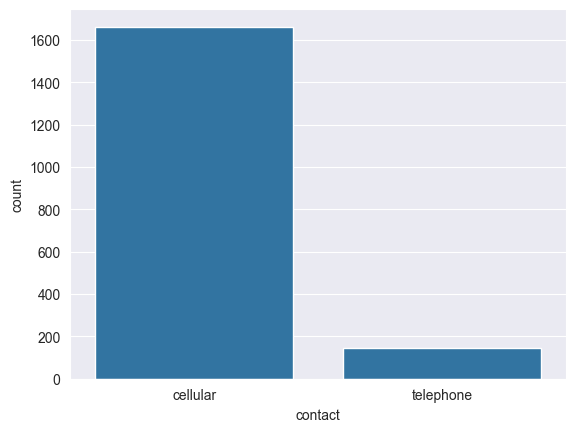

In [19]:
# Contact
sns.barplot(x=df['contact'].value_counts().index, y=df['contact'].value_counts())

In [20]:
df['contact'].unique()

array(['cellular', 'telephone', nan], dtype=object)

In [21]:
df['contact'].value_counts()

contact
cellular     1663
telephone     146
Name: count, dtype: int64

In [22]:
contact_NaN = len(df) - df['contact'].value_counts().sum()
print(contact_NaN)

191


Contacts is missing just about 10% (191/2000) of the data, on top of this, the only two categories are cellular and telephone meaning it is probably safe to fill in the missing values with the mode.

In [23]:
df['contact'].fillna(df['contact'].mode()[0], inplace=True)

In [28]:
# poutcome
poutcome_NaN = len(df) - df['poutcome'].value_counts().sum()

print(df['poutcome'].value_counts(), df['poutcome'].unique(), "NaN:", poutcome_NaN)


poutcome
failure    955
success    444
other      147
Name: count, dtype: int64 ['failure' 'other' 'success' nan] NaN: 454


poutcome has a high percentage of missing values, 22.7% (454/2000). But from looking at the dataset, these NaN poutcome values might have meaning when we look at the "previous" column.

In [29]:
df_NaN_poutcome = df[df['poutcome'].isna()]
df_NaN_poutcome['previous'].value_counts()

previous
0    454
Name: count, dtype: int64

The "previous" has direct correlation with the "poutcome" column. If the "previous" column is 0, then the "poutcome" is NaN. This most likely indicates that these are new customers so we will create this category.

In [30]:
df['poutcome'].fillna('new customer', inplace=True)

poutcome_NaN = len(df) - df['poutcome'].value_counts().sum()

print(df['poutcome'].value_counts(), df['poutcome'].unique(), "NaN:", poutcome_NaN)

poutcome
failure         955
new customer    454
success         444
other           147
Name: count, dtype: int64 ['failure' 'other' 'success' 'new customer'] NaN: 0


In [31]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

All missing values have been dealt with :)

## Process and Encode the Categorical Features

### Jobs

In [32]:
df['job'].unique()

array(['technician', 'retired', 'blue-collar', 'self-employed',
       'services', 'management', 'admin.', 'unemployed', 'student',
       'entrepreneur', 'housemaid'], dtype=object)

Jobs have 12 unique values. We can encode these using one-hot encoding (For nominal categorical variables).